<a href="https://colab.research.google.com/github/jeanbai/Human-Protein-Cell-Classification/blob/main/Human_Protein_Cell_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [2]:
import math, re, os
import numpy as np
import tensorflow as tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [5]:

import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from tqdm import tqdm

Import label dataset

In [8]:
data = pd.read_csv("/content/drive/MyDrive/train.csv")

In [9]:
data.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [9]:
label_names = {
    '0': "Nucleoplasm",
    '1': "Nuclear membrane",
    '2': "Nucleoli",
    '3': "Nucleoli fibrillar center",
    '4': "Nuclear speckles",
    '5': "Nuclear bodies",
    '6': "Endoplasmic reticulum",
    '7': "Golgi apparatus",
    '8': "Intermediate filaments",
    '9': "Actin filaments",
    '10': "Microtubules",
    '11': "Mitotic spindle",
    '12': "Centrosome",
    '13': "Plasma membrane",
    '14': "Mitochondria",
    '15': "Aggresome",
    '16': "Cytosol",
    '17': "Vesicles and punctate cytosolic patterns",
    '18': "Negative",
}

Apply Hot_Encode for multi_label categories

In [10]:
train = data.copy()
lab_idx = label_names.keys()

train['Label'] = train['Label'].map(lambda x: x.split('|'))

for label in lab_idx:
    train[label_names[label]] = train['Label'].map(lambda result: 1 if label in result else 0)

In [11]:
train.head()

,ID,Label,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Intermediate filaments,Actin filaments,Microtubules,Mitotic spindle,Centrosome,Plasma membrane,Mitochondria,Aggresome,Cytosol,Vesicles and punctate cytosolic patterns,Negative
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,"[8, 5, 0]",1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,"[6, 1]",0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,"[16, 10]",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,"[14, 0]",1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [12]:
train.shape

(21806, 21)

Import image file

In [13]:
img_width = 150
img_height = 150

X = []

for i in tqdm(range(train.shape[0])):
    path = '/content/drive/MyDrive/rgb/' + train['ID'][i] + '.png'
    img = image.load_img(path, target_size=(img_width, img_height, 3))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)

X = np.array(X)


100%|██████████| 21806/21806 [1:19:58<00:00,  4.54it/s]


In [14]:
X.shape

(21806, 150, 150, 3)

In [15]:
X.dtype

dtype('float32')

Visualize one of the image

Chose one of the image to have a look

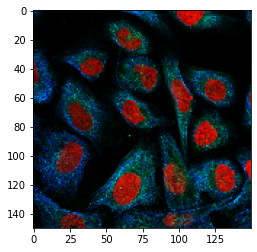

In [16]:
plt.imshow(X[3])

In [34]:
train_df['Label'][3]

['16', '10']

In [17]:
train.shape

(21806, 21)

In [18]:
y = train.drop(['ID','Label'],axis = 1)
y = y.to_numpy()
y.shape

(21806, 19)

Split dateset for modeling

In [20]:
X_train, X_test,y_train,y_test = train_test_split(X, y,random_state = 0, test_size = 0.30)

In [21]:
X_train[0].shape

(150, 150, 3)

##built CNN

In [22]:
model = Sequential()
model.add(Conv2D(16,(3,3), activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))


model.add(Conv2D(32,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))


model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))


model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(19, activation='sigmoid'))



In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0

In [24]:
model.compile(optimizer="adam", loss = 'binary_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Epoch 1/20
477/477 [==============================] - 80s 165ms/step - loss: 0.6332 - accuracy: 0.1313 - val_loss: 0.3327 - val_accuracy: 0.4034
Epoch 2/20
477/477 [==============================] - 79s 165ms/step - loss: 0.2429 - accuracy: 0.3688 - val_loss: 0.3369 - val_accuracy: 0.3863
Epoch 3/20
477/477 [==============================] - 79s 165ms/step - loss: 0.2303 - accuracy: 0.3920 - val_loss: 0.8572 - val_accuracy: 0.3962
Epoch 4/20
477/477 [==============================] - 79s 165ms/step - loss: 0.2232 - accuracy: 0.4061 - val_loss: 0.4844 - val_accuracy: 0.4204
Epoch 5/20
477/477 [==============================] - 80s 168ms/step - loss: 0.2165 - accuracy: 0.4308 - val_loss: 0.2229 - val_accuracy: 0.4743
Epoch 6/20
477/477 [==============================] - 78s 165ms/step - loss: 0.2108 - accuracy: 0.4362 - val_loss: 0.2351 - val_accuracy: 0.4363
Epoch 7/20
477/477 [==============================] - 79s 165ms/step - loss: 0.2077 - accuracy: 0.4398 - val_loss: 0.2122 - val_ac

The result is not good. The image date is imbalanced. The numbe of blue channels image file is very a little. Will Use Stratified Sheffle Split method to seperate the train and test file for a better balanced train and test file.

In [ ]:
#from imblearn.over_sampling import SMOTE
#smote= SMOTE()

#X_smote, y_smote = smote.fit_resample(X,y)

In [39]:
def plot_learningCurve(history,epoch):
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range,history.history['val_accuracy'])
    plt.title("Model Accuracy")
    plt.ylabel('accuracy')
    plt.xlabel("Epoch")
    plt.legend(["Train",'Val'], loc='upper left')
    plt.show()

    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title("Model Loss")
    plt.ylabel('Loss')
    plt.xlabel("Epoch")
    plt.legend(["Train",'Val'], loc='upper left')
    plt.show()